In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error

item_data = pd.read_csv(r"C:\Users\sung1\OneDrive\桌面\sales\items.csv")
item_cat_data = pd.read_csv(r"C:\Users\sung1\OneDrive\桌面\sales\item_categories.csv")
train_data = pd.read_csv(r"C:\Users\sung1\OneDrive\桌面\sales\sales_train.csv")
test_data = test_data = pd.read_csv(r"C:\Users\sung1\OneDrive\桌面\sales\test.csv")
train_data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<AxesSubplot:xlabel='item_cnt_day'>

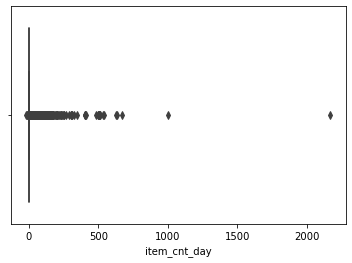

In [2]:
sns.boxplot(train_data['item_cnt_day'])

In [3]:
train_data['year'] = train_data['date'].apply(lambda x: x.split('.')[2]).astype('int')
train_data['month'] = train_data['date'].apply(lambda x: x.split('.')[1]).astype('int')
train_data['day'] = train_data['date'].apply(lambda x: x.split('.')[0]).astype('int')

# train 整理
train_data['YMD']= train_data['year'].astype('str') +train_data['month'].astype('str') +train_data['day'].astype('str')
train_data['YM']= train_data['year'].astype('str') +train_data['month'].astype('str')

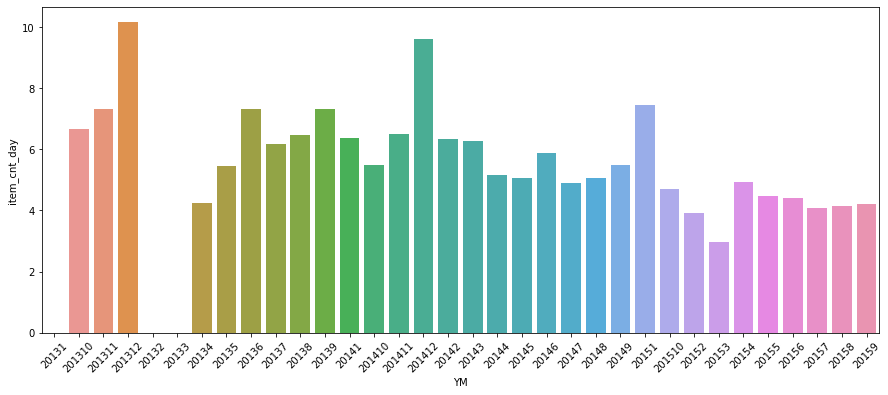

In [4]:
def plot_trend(data, date, count, item_id):
    plt.figure(figsize= (15, 6))
    sns.barplot(x=data[date], y=data[count][data['item_id']==item_id],ci=0)
    plt.xticks(rotation=45)
plot_trend(train_data, 'YM', 'item_cnt_day', 20949)

In [20]:
# RF 預測價格
def RF(train_data, y, n_estimator, depth, leaf):
    x_train, x_test, y_train, y_test = train_test_split(train_data.drop(y, axis=1), train_data[y], random_state=0, test_size=0.2)
    rf = RandomForestRegressor(n_estimators=n_estimator, max_depth= depth, min_samples_leaf=leaf)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    return(rf, y_pred, y_test)

train_rf_price = train_data.drop(['date', 'item_cnt_day', 'YM', 'YMD', 'year','month','day'], axis =1)
train_rf_price= pd.merge(train_rf_price, item_data.loc[:,['item_id', 'item_category_id']] ,how='left', on='item_id') 

In [21]:
train_rf_price

,date_block_num,shop_id,item_id,item_price,item_category_id
0,0,59,22154,999.00,37
1,0,25,2552,899.00,58
2,0,25,2552,899.00,58
3,0,25,2554,1709.05,58
4,0,25,2555,1099.00,56
...,...,...,...,...,...
2935844,33,25,7409,299.00,55
2935845,33,25,7460,299.00,55
2935846,33,25,7459,349.00,55
2935847,33,25,7440,299.00,57


In [22]:
rf_model_price, y_price_pred, y_price_test = RF(train_rf_price, 'item_price', 100, 6, 2)
print("PRICE MSE:", mean_squared_error(y_price_pred, y_price_test))

PRICE MSE: 409292.0550907827


In [24]:
# test data 整理
test_data.insert(1, 'date_block_num', 34)
test_data= pd.merge(test_data, item_data.loc[:,['item_id', 'item_category_id']] ,how='left', on='item_id') 

In [26]:
test_pred_price = rf_model_price.predict(test_data.drop('ID', axis=1).values)
test_data['item_price']= test_pred_price

In [9]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

train_ks_data= train_data.drop(['date', 'YM', 'YMD', 'day'], axis =1)
train_ks_data= pd.merge(train_ks_data, item_data.loc[:,['item_id', 'item_category_id']] ,how='left', on='item_id') 

In [10]:
distortions=[] 
scores = []
k_range = range(2,10)
kx = train_ks_data.astype('float').values

# 記錄每種 K 值建出的 KMeans 模型的成效
for i in k_range:
    kmeans = KMeans(n_clusters=i).fit(kx)
    distortions.append(kmeans.inertia_) # 誤差平方和 (SSE)
    #scores.append(silhouette_score(kx, kmeans.predict(kx))) # 側影係數

In [15]:
kmeans = KMeans(n_clusters=5).fit(kx)
dy = kmeans.predict(kx)
train_ks_data['cluster']=dy

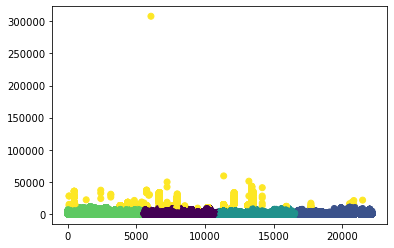

In [16]:
# 分群圖
plt.scatter(train_ks_data['item_id'], train_ks_data['item_price'], c= train_ks_data['cluster'])

In [28]:
# month item cnt
train_month_data = train_ks_data.groupby(['date_block_num', 'shop_id', 'item_id',
                                           'item_category_id']).agg({'item_price':'mean', 'item_cnt_day':'sum'}).reset_index()

# two clusters by price(9200)
train_cnt_low = train_month_data[train_month_data['item_price']<=9200]
rf_model_cnt_low, y_cnt_low_pred, y_cnt_low_test= RF(train_cnt_low, 'item_cnt_day', 100, 6, 2) 
mean_squared_error(y_cnt_low_pred, y_cnt_low_test)

train_cnt_high = train_month_data[train_month_data['item_price']>9200]
rf_model_cnt_high, y_cnt_high_pred, y_cnt_high_test= RF(train_cnt_high, 'item_cnt_day', 100, 6, 2) 
mean_squared_error(y_cnt_high_pred, y_cnt_high_test)

# test
test_low = test_data[test_data['item_price']<=9200].drop('ID', axis=1)
test_low_pred = rf_model_cnt_low.predict(test_low)
test_low['item_cnt_month'] = test_low_pred

test_high = test_data[test_data['item_price']>9200].drop('ID', axis=1)
test_high_pred = rf_model_cnt_high.predict(test_high)
test_high['item_cnt_month'] = test_high_pred